# Integerating Vector and Raster

## References 

https://gdal.org/programs/gdal_polygonize.html 


## Prerequisites

Is GDAL installed?

In [1]:
import sys
try:
    from osgeo import ogr, osr, gdal, gdal_array as gdarr
    print("Installed!")
except:
    sys.exit('ERROR: cannot find GDAL/OGR modules')

Installed!


In [2]:
dsPath = path_to_2014_tiff = r"C:\Users\Zako3\Downloads\Handouts\exercise_data_raster_vector\2014.tif"
nlprovPath = r"/home/user/Handouts/exercise_data_raster_vector/NL_provinces.shp"
roadsVectorDsPath = r'/home/user/Handouts/exercise_data_raster_vector/ovRoads.geojson'

print(dsPath)
print()
print(nlprovPath)
print()
print(roadsVectorDsPath)

C:\Users\Zako3\Downloads\Handouts\exercise_data_raster_vector\2014.tif

/home/user/Handouts/exercise_data_raster_vector/NL_provinces.shp

/home/user/Handouts/exercise_data_raster_vector/ovRoads.geojson


## Extracting raster pixels intersecting polygons


Subsetting a raster based on a polygon

Determine temperature pixels inside Overijssel province only.

In [13]:
import os

overTemperatureDsPath = 'temOverijssel.tif'

ds = gdal.Open(dsPath)

overTemperatureDs = gdal.Warp(overTemperatureDsPath,
                              ds,
                              format='GTiff',
                              dstSRS='EPSG:28992',
                              cutlineDSName=nlprovPath,
                              cutlineWhere="NAME_1 = 'Overijssel'",
                              cropToCutline=True)

# we determined temperature pixels inside Overijssel province only.

In [14]:
#To confirm lets show the temperature for the first day

from matplotlib import pyplot as plt

overTempArray=gdarr.DatasetReadAsArray(overTemperatureDs, 0, 0, 
                                       overTemperatureDs.RasterXSize, 
                                       overTemperatureDs.RasterYSize)

overTempArray[overTempArray == -9999] = None
plt.imshow(overTempArray[0,:,:])
plt.show()
plt.tight_layout()


AttributeError: 'NoneType' object has no attribute 'RasterXSize'

Extract temperature inside Utrecht province - **Exercise 1**

In [39]:
utrechtTemperatureDsPath = 'tempUtrecht.tif'

utrechtTemperatureDs = None

# YOUR CODE HERE
utrechtTemperatureDs = gdal.Warp(utrechtTemperatureDsPath,
                              ds,
                              format='GTiff',
                              dstSRS='EPSG:28992',
                              cutlineDSName=nlprovPath,
                              cutlineWhere="NAME_1 = 'Utrecht'",
                              cropToCutline=True)

utrechtTempArray=gdarr.DatasetReadAsArray(utrechtTemperatureDs, 0, 0, utrechtTemperatureDs.RasterXSize, utrechtTemperatureDs.RasterYSize)
utrechtTempArray[utrechtTempArray == -9999] = None
plt.imshow(utrechtTempArray[0,:,:])
plt.show()
utrechtTemperatureDs = None

AttributeError: 'NoneType' object has no attribute 'RasterXSize'

## Rasterize a vector layer

### How to rasterize all the roads using number of cars per hour?

1. Subset only Overijssel Temperatures, ***in memory***, to use later as a reference

In [12]:
from osgeo import ogr, gdal, gdal_array
from matplotlib import pyplot as plt
import numpy as np
import os

overTemperatureDs=gdal.Warp('', dsPath, 
    format="Mem",
    dstSRS='EPSG:28992',
    cutlineDSName=nlprovPath,
    cutlineWhere="NAME_1='Overijssel'", 
    dstNodata=-9999,
    cropToCutline = True, 
    outputType=gdal.GDT_Float32)

overTempArray=gdarr.DatasetReadAsArray(overTemperatureDs, 0, 0, overTemperatureDs.RasterXSize, overTemperatureDs.RasterYSize)


2. Create an empty raster in memory to carry the rasterized version of the road layer \- **Exercise 2**  



In [13]:
# YOUR CODE HERE

# 1- Create a driver
driver = gdal.GetDriverByName('Mem')

# 2- Create a new raster
roadsRasterDs = driver.Create('', overTemperatureDs.RasterXSize, overTemperatureDs.RasterYSize, 1, gdal.GDT_Float32)


# C3- Assign a projection
prj = overTemperatureDs.GetProjection()
roadsRasterDs.SetProjection(prj)

# 4- Set the GeoTransform
t = overTemperatureDs.GetGeoTransform()
roadsRasterDs.SetGeoTransform(t)

band = roadsRasterDs.GetRasterBand(1)
band.SetNoDataValue(0)
band.FlushCache()
print('Finish')


Finish


3. Rasteriation

In [14]:
roadsVectorDs = ogr.Open(roadsVectorDsPath)
roadsLayer = roadsVectorDs.GetLayer()

#  rasterize A1 road in Overijssel
gdal.RasterizeLayer(roadsRasterDs, [1], roadsLayer,
                        options =[ 'ATTRIBUTE=vehic_p_hour'])
# Check slides page 9 
# gdal.RasterizeLayer(dataset, [bands], layer, burn_values, options)

0

4. Plot the output raster - **Exercise 3**

(80, 87)


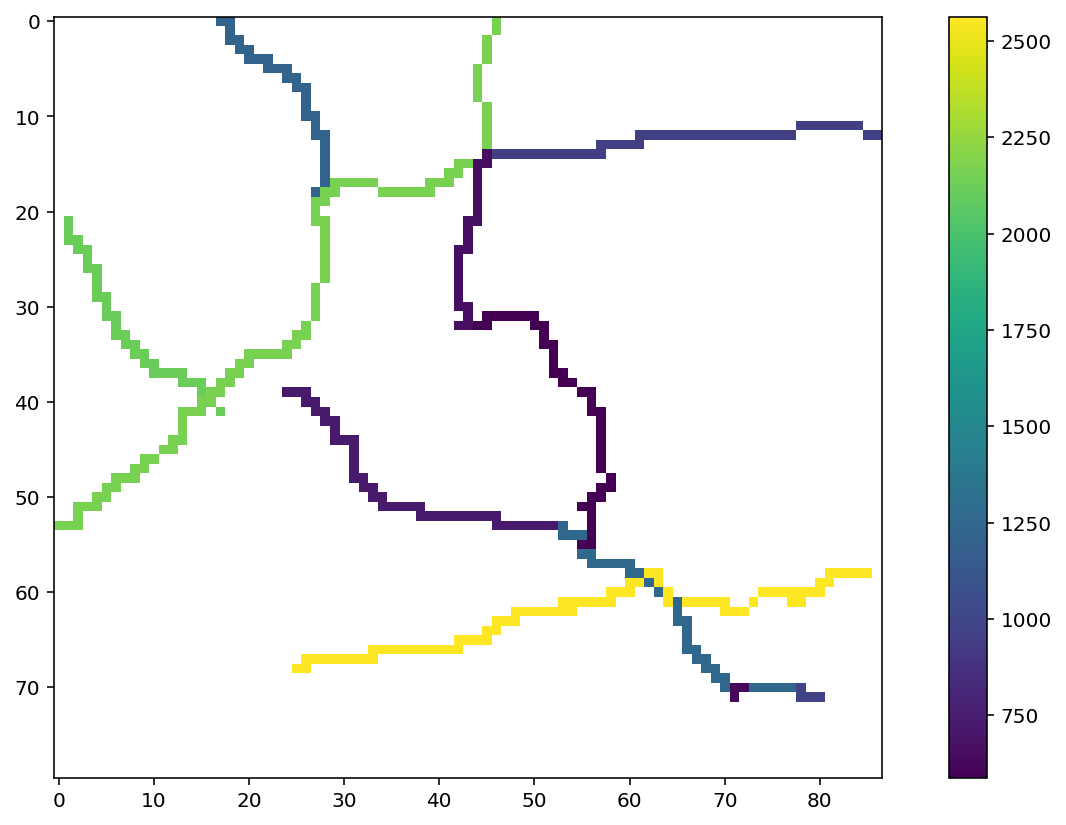

In [15]:
roadsArray = gdarr.DatasetReadAsArray(roadsRasterDs,0, 0, roadsRasterDs.RasterXSize, roadsRasterDs.RasterYSize)
print(roadsArray.shape)
roadsArray[roadsArray==0] = None

plt.imshow(roadsArray)
plt.colorbar()
plt.show()

## A Sample Analysis

How to rasterize only one road out of a dataset of the main roads of Overijssel using 0 and 1 as pixel values?

Example:
What were the lowest temperatures felt in 2014 on motorway A1 in the province of Overijssel?

1- Subset the temperatures of Overijssel 

In [46]:
print('already done')

already done


2-Open road dataset and filter A1 road from the roads dataset

In [16]:
roadsVectorDs = ogr.Open(roadsVectorDsPath)
roadsLayer = roadsVectorDs.GetLayer()
roadsLayer.SetAttributeFilter("id='A1'")

0

3-Rasterize roads dataset
- Create an empty raster dataset for A1 road

In [21]:
# Create the dataset
memDriver = gdal.GetDriverByName('Mem')
roadsRasterDs = memDriver.Create('', overTemperatureDs.RasterXSize, overTemperatureDs.RasterYSize,1,gdal.GDT_Float32)

# Set projection and geotransform
roadsRasterDs.SetProjection(overTemperatureDs.GetProjection())
roadsRasterDs.SetGeoTransform(overTemperatureDs.GetGeoTransform())

# Create 1 band and set the nodata
outband1 = roadsRasterDs.GetRasterBand(1)
outband1.SetNoDataValue(0)

0

- Rasterize - **Exercise 4**

In [22]:
# YOUR CODE HERE
# raise NotImplementedError()

roadsRaster = ogr.Open(roadsVectorDsPath)
roadsRaster = roadsVectorDs.GetLayer()

#  rasterize A1 road in Overijssel
gdal.RasterizeLayer(roadsRasterDs, [1], roadsLayer, burn_values = [1],
                        options =[ 'ALL_TOUCHED = FALSE'])


0

4-Convert rasterized dataset to numpy

In [23]:
import numpy as np

roadsArray=gdarr.DatasetReadAsArray(roadsRasterDs, 0, 0, roadsRasterDs.RasterXSize, roadsRasterDs.RasterYSize)


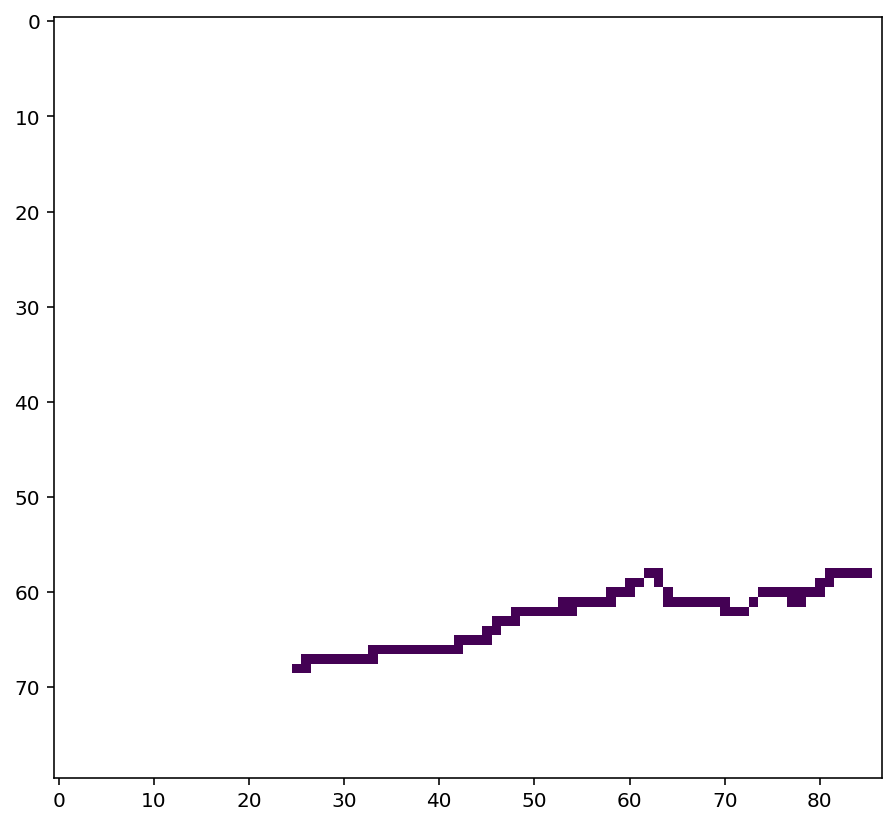

In [24]:
from matplotlib import pyplot as plt
roadsArray[roadsArray==0] = None
plt.imshow(roadsArray)
plt.show()

5- Multiply A1 numpy array by the temperature array - **Exercise 5**

In [ ]:
# YOUR CODE HERE
#raise NotImplementedError()



In [56]:
print(f"shape of the filter: {roadsArray.shape}")
print(f"shape of the temprature array: {overTempArray.shape}")

shape of the filter: (80, 87)
shape of the temprature array: (365, 80, 87)


In [25]:
roadsTemperature = None

### BEGIN SOLUTION

roadsTemperature = roadsArray * overTempArray
roadsTemperature[roadsTemperature == -9999] = None
print('A1 road temperatures shape:', roadsTemperature.shape)

### END SOLUTION

A1 road temperatures shape: (365, 80, 87)


- Visualize road A1 temperature for day number 150 - **Exercise 6**



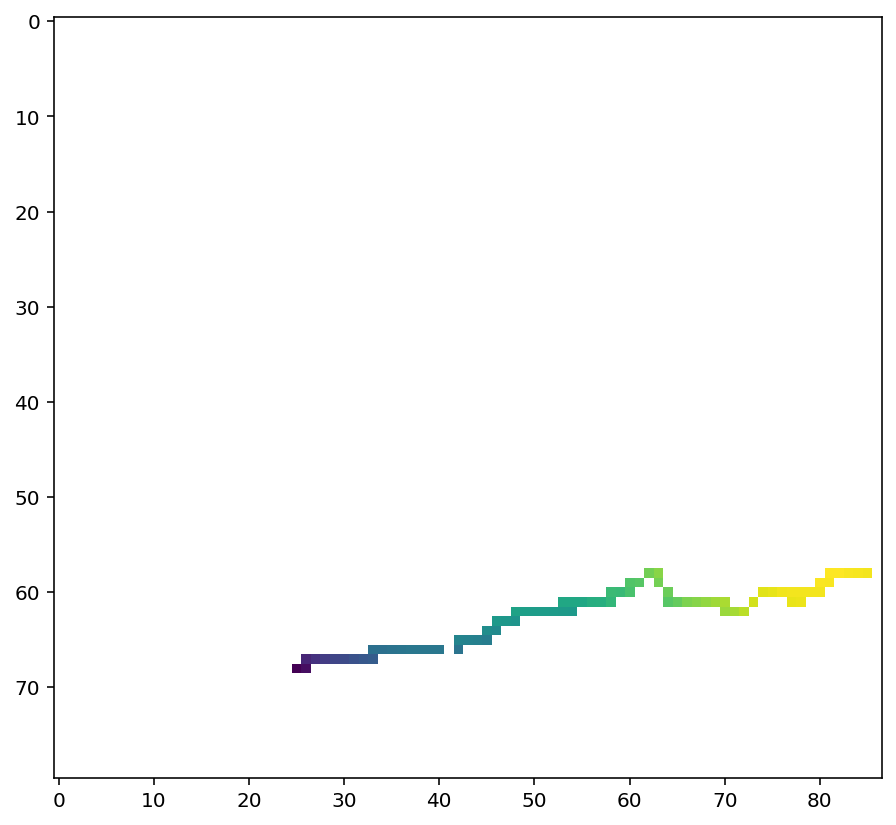

In [26]:
# YOUR CODE HERE
#raise NotImplementedError()

plt.imshow(roadsTemperature[149])

6-Compute lower temperature for every pixel on the road - **Exercise 7**

In [28]:
# YOUR CODE HERE
#raise NotImplementedError()

np.nanmin(roadsTemperature, axis=0).shape

/tmp/ipykernel_4193/1352116402.py:4: RuntimeWarning: All-NaN slice encountered
  np.nanmin(roadsTemperature, axis=0).shape


(80, 87)

7-Extract min and max from the previous numpy array (lowest temperatures) - **Exercise 8**

In [31]:
# YOUR CODE HERE
# raise NotImplementedError()


np.nanmax(roadsTemperature, axis=0).shape

/tmp/ipykernel_4193/3196786966.py:5: RuntimeWarning: All-NaN slice encountered
  np.nanmax(roadsTemperature, axis=0).shape


(80, 87)